205
4096
1000
1000


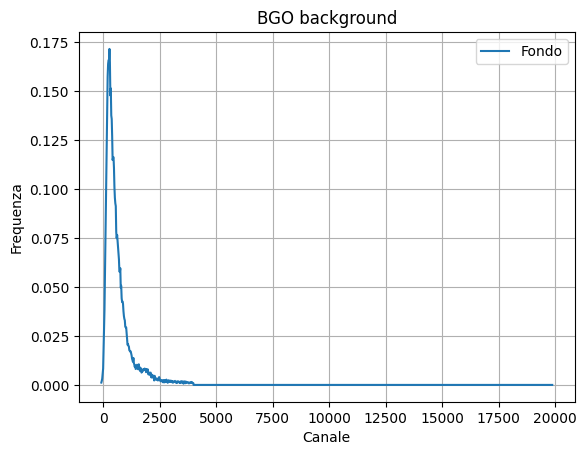

In [19]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

data = pd.read_csv(r'C:\Users\Black\Desktop\Esperimentazioni di Nucleare e Subnucleare\SiPM\Caratterizzazione Cristalli\BGO\Fondo BGO\BGO-fondo-newgate.CSV', sep=';') # fondo
data1 = pd.read_csv(r'C:\Users\Black\Desktop\Esperimentazioni di Nucleare e Subnucleare\SiPM\Caratterizzazione Cristalli\BGO\Sodio\SpettroNa_2ndRun.csv', sep=' \t', engine='python')

print(len(data['Channel']))
print(len(data1['Channel']))


channel_back = np.array(data['Channel']) #taglio i dati per avere lo stesso numero di elementi
counts_back = np.array(data['Counts'])
time_back = 9218 #s
frequency_back = counts_back/time_back

channel_Na = np.array(data1['Channel'][:1000])
counts_Na = np.array(data1['Counts'][:1000])
time_Na = 300 #s
frequency_Na = counts_Na/time_Na

# devo allungare il fondo con tanti zeri
allungo_x = np.arange(3990, 100000000, 20)
allungo_y = np.zeros(len(allungo_x))
channel_back = np.concatenate((channel_back, allungo_x))[:1000]
frequency_back = np.concatenate((frequency_back, allungo_y))[:1000]

print(len(channel_back))
print(len(frequency_Na))

plt.plot(channel_back, frequency_back, label='Fondo')
plt.xlabel('Canale')
plt.ylabel('Frequenza')
plt.title('BGO background')
plt.legend()
plt.grid()
plt.show()

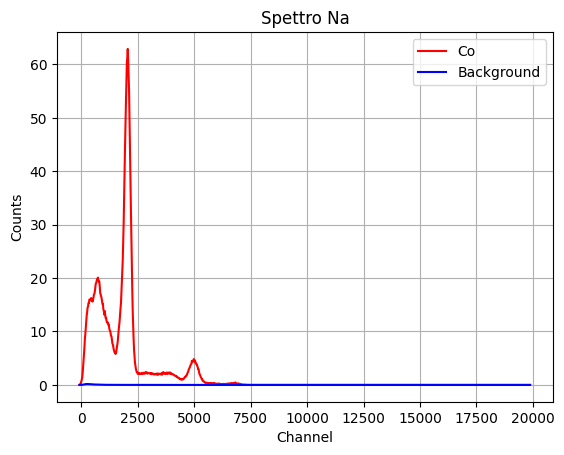

In [20]:
plt.plot(channel_Na, frequency_Na, marker='', linestyle='-', color='red', label='Co')
plt.plot(channel_back, frequency_back, marker='', linestyle='-', color='blue', label='Background')
plt.xlabel('Channel')
plt.ylabel('Counts')
plt.title('Spettro Na')
plt.legend()
plt.grid()
plt.show()

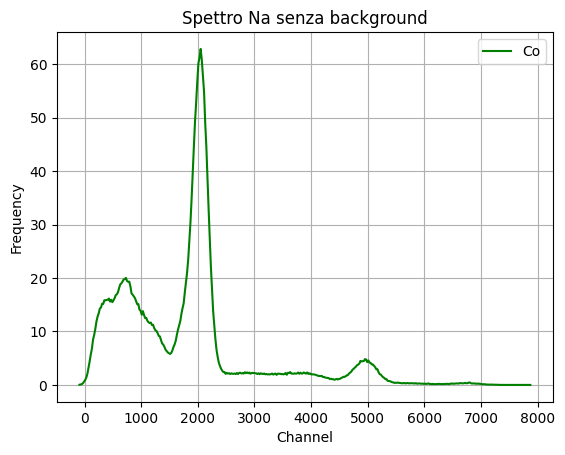

In [21]:
channel = channel_back
frequency = frequency_Na - frequency_back

for i in range(len(frequency)):
    if frequency[i] < 0:
        frequency[i] = 0

plt.plot(channel[:400], frequency[:400], marker='', linestyle='-', color='green', label='Co')
plt.xlabel('Channel')
plt.ylabel('Frequency')
plt.legend()
plt.title('Spettro Na senza background')
plt.grid()

In [22]:
from iminuit import Minuit
from iminuit.cost import LeastSquares
from scipy.stats import norm, chi2


def repeat_fit(ls, left_bound, right_bound, mu, sigma, A, ampiezza_picco_limite, dis=False, limit_ADC=100):
    '''
    ampiezza picco limite = è la ampiezza dell'intorno di mu in cui è accettabile avere il picco
    '''
    peak_list = []
    error_peak_list = []
    sigma_list = []
    error_sigma_list = []
    for delta_ADC in np.arange(0, abs(right_bound-left_bound)/2+limit_ADC, 10):
        ls.mask = (channel > left_bound+delta_ADC) & (channel < right_bound-delta_ADC)
        m = Minuit(ls, mu=mu, sigma=sigma, A=A)
        m.migrad()
        m.hesse()
        p_value = (1. - chi2.cdf (m.fval, df = m.ndof))
        if p_value > 0.05 and m.valid == True:
            if m.values['mu'] < (mu+ampiezza_picco_limite/2) and m.values['mu'] > (mu-ampiezza_picco_limite/2):    
                peak_list.append(m.values['mu'])
                error_peak_list.append(m.errors['mu'])
                sigma_list.append(m.values['sigma'])
                error_sigma_list.append(m.errors['sigma'])
                if dis==True: display(m)
        ls.mask = None
    for delta_ADC in np.arange(0, abs(right_bound-left_bound)/2+limit_ADC, 10):
        ls.mask = (channel > left_bound+delta_ADC) & (channel < right_bound-delta_ADC/2)
        m = Minuit(ls, mu=mu, sigma=sigma, A=A)
        m.migrad()
        m.hesse()
        p_value = (1. - chi2.cdf (m.fval, df = m.ndof))
        if p_value > 0.05 and m.valid == True:
            if m.values['mu'] < (mu+ampiezza_picco_limite/2) and m.values['mu'] > (mu-ampiezza_picco_limite/2):    
                peak_list.append(m.values['mu'])
                error_peak_list.append(m.errors['mu'])
                sigma_list.append(m.values['sigma'])
                error_sigma_list.append(m.errors['sigma'])
                if dis==True: display(m)
        ls.mask = None
    for delta_ADC in np.arange(0, abs(right_bound-left_bound)/2+limit_ADC, 10):
        ls.mask = (channel > left_bound+delta_ADC/2) & (channel < right_bound-delta_ADC)
        m = Minuit(ls, mu=mu, sigma=sigma, A=A)
        m.migrad()
        m.hesse()
        p_value = (1. - chi2.cdf (m.fval, df = m.ndof))
        if p_value > 0.05 and m.valid == True:
            if m.values['mu'] < (mu+ampiezza_picco_limite/2) and m.values['mu'] > (mu-ampiezza_picco_limite/2):    
                peak_list.append(m.values['mu'])
                error_peak_list.append(m.errors['mu'])
                sigma_list.append(m.values['sigma'])
                error_sigma_list.append(m.errors['sigma'])
                if dis==True: display(m)
        ls.mask = None
    return np.array(peak_list), np.array(error_peak_list), np.array(sigma_list), np.array(error_sigma_list)

In [23]:
def func(x, mu, sigma, A):
    return A * norm.pdf(x, mu, sigma)

error = np.sqrt(counts_Na)/time_Na

ls = LeastSquares(channel, frequency, error, func)

peak_list511, error_peak_list511, sigma_list511, err_sigma_list511 = repeat_fit(ls, 1850, 2250, 2050, 200, 62, 70, dis=False)

print(peak_list511)
print(error_peak_list511)

[2043.57842466 2043.57842466 2043.9283202  2043.9283202  2042.30888456
 2042.30888456 2044.01005707 2044.01005707 2043.10037498 2043.10037498
 2044.008658   2044.008658   2054.934965   2054.934965   2048.05798142
 2048.05798142 2037.40119454 2037.40119454]
[ 0.84378598  0.84378598  1.93390375  1.93390375  0.67436869  0.67436869
  1.22154453  1.22154453  1.91895775  1.91895775  3.35414828  3.35414828
 11.29183376 11.29183376  3.42380269  3.42380269 10.71927428 10.71927428]


In [24]:
peak_list1274_5, error_peak_list1274_5, sigma_list1274_5, err_sigma_list1274_5 = repeat_fit(ls, 4600, 5300, 4970, 250, 4, 100, dis=False, limit_ADC=200)

print(peak_list1274_5)
print(error_peak_list1274_5)

[4952.43744466 4952.43744466 4953.99196949 4953.99196949 4952.24607045
 4952.24607045 4950.40560463 4950.40560463 4948.86071765 4948.86071765
 4949.66531707 4954.23542847 4953.96785948 4953.96785948 4941.23889762
 4944.14227058 4953.17587919 4953.17587919 4932.59077655 4932.59077655
 4983.14223431 4952.80557978 4952.80557978 4952.58749389 4951.46714177
 4951.46714177 4951.89760172 4951.89760172 4953.37304653 4951.1863753
 4949.38429272 4983.10612862 4937.8688309  4925.2206191 ]
[ 2.58423188  2.58423188  2.96010687  2.96010687  3.77061996  3.77061996
  4.01260963  4.01260963  1.83319549  1.83319549  1.9408046   2.93852496
  3.46543529  3.46543529  9.02028194  8.39341983  8.92331168  8.92331168
 28.2965398  28.2965398  48.06596085  2.88783182  2.88783182  3.2931997
  3.8075147   3.8075147   5.779763    5.779763    7.55015859  7.10331619
 11.94949143 53.99118237 51.19400222 47.84290378]


In [25]:
def weighted_mean(values, errors):
    mean = np.sum(values/(errors**2))/np.sum(1/(errors**2))
    error_mean = np.sqrt((abs(np.max(values) - np.min(values))/2)**2 + (1/np.sum(1/(errors**2))))
    return mean, error_mean

# first peak at 511 KeV
mean511, error_mean511 = weighted_mean(peak_list511, error_peak_list511)
print(mean511, error_mean511)

# second peak at 1274.5 KeV
mean1274_5, error_mean1274_5 = weighted_mean(peak_list1274_5, error_peak_list1274_5)
print(mean1274_5, error_mean1274_5)

2043.1621173215874 8.77258291142473
4951.385082741235 28.967536410080484


In [26]:
picchi1 = np.array([484.25640155547296, 1125.2734209588605, mean511, mean1274_5, 10962.757949349794])
err_picchi1 = np.array([10, 12.680413758184507, 10, error_mean1274_5, 118.82749241644167])
energia1 = np.array([122.1, 300.1, 511, 1274.5, 2615]) # NOTA: con BGO non c'è il picco a 14.4 KeV

def line(x, m, q):
    return m*x + q

ls3 = LeastSquares(energia1, picchi1, err_picchi1, line)
m3 = Minuit(ls3, m=1, q=0)
m3.migrad()
m3.hesse()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 62.29 (χ²/ndof = 20.8)     │              Nfcn = 47               │
│ EDM = 3.09e-16 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ m    │   3.980   │   0.021   │            │            │         │         │       │
│ 1 │ q    │    -17    │    10     │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬─────────────────────┐
│   │         m         q │
├───┼─────────────────────┤
│ m │   0.00046 -165.8e-3 │
│ q │ -165.8e-3      96.1 │
└───┴─────────────────────┘

In [27]:
def parabola(x, a, x0, y0):
    return y0 + a*(x-x0)**2

ls4 = LeastSquares(energia1, picchi1, err_picchi1, parabola)
m4 = Minuit(ls4, a=-0.0002, x0=80000, y0=130000)
m4.migrad()
m4.hesse()
print(m4.fval)

70.39708988461204


In [28]:
def func1(x, a, b):
    return b*(1 - np.exp(-a*x))

ls5 = LeastSquares(energia1, picchi1, err_picchi1, func1)
m5 = Minuit(ls5, a=0.01, b=10000)
m5.migrad()
m5.hesse()

C:\Users\Black\AppData\Local\Temp\ipykernel_9844\3230248521.py:2: RuntimeWarning:

overflow encountered in exp



┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 80.41 (χ²/ndof = 26.8)     │              Nfcn = 562              │
│ EDM = 0.485 (Goal: 0.0002)       │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │   ABOVE EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │  18.1e-6  │  1.2e-6   │            │            │         │         │       │
│ 1 │ b    │  0.220e6  │  0.014e6  │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬─────────────────────────────────────┐
│   │                 a                 b │
├───┼─────────────────────────────────────┤
│ a │          1.33e-12 -16.0501893334e-3 │
│ b │ -16.0501893334e-3          1.94e+08 │
└───┴─────────────────────────────────────┘

[122.1, 300.1, 511.0, 1274.5, 2615.0
[484.25640155547296, 1125.2734209588605, 2043.1621173215874, 4951.385082741235, 10962.757949349794
[10.0, 12.680413758184507, 10.0, 28.967536410080484, 118.82749241644167]
parametri esponenziale: <ValueView a=1.8092989501617642e-05 b=219871.22651514484>
errori parametri esponenziale: <ErrorView a=1.1547031884476644e-06 b=13919.286076137916>


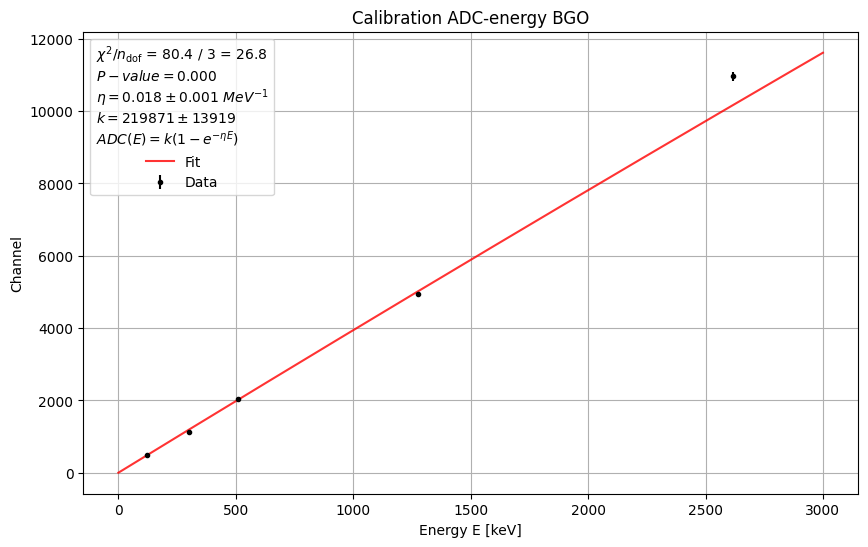

In [29]:
# plot dell'esponenziale e della parabola sovrapposti

x = np.linspace(0, 3000, 1000)
y = func1(x, *m5.values)
y1 = parabola(x, *m4.values)
y2 = line(x, *m3.values)

plt.subplots(figsize=(10, 6))
plt.plot(x, y, label='Fit', color='red', alpha=0.8)

plt.errorbar(energia1, picchi1, err_picchi1, fmt='.', linestyle='', label='Data', color='black')
print(f'[{energia1[0]}, {energia1[1]}, {energia1[2]}, {energia1[3]}, {energia1[4]}')
print(f'[{picchi1[0]}, {picchi1[1]}, {picchi1[2]}, {picchi1[3]}, {picchi1[4]}')
print(f'[{err_picchi1[0]}, {err_picchi1[1]}, {err_picchi1[2]}, {err_picchi1[3]}, {err_picchi1[4]}]')

p_value = (1. - chi2.cdf(m5.fval, df=m5.ndof))

fit_info = [f"$\\chi^2$/$n_\\mathrm{{dof}}$ = {m5.fval:.1f} / {m5.ndof:.0f} = {m5.fval/m5.ndof:.1f}",]
fit_info.append(f"$P-value = {p_value:.3f}$")
fit_info.append(f"$\eta = {m5.values['a']*10**3:.3f} \pm {m5.errors['a']*10**3:.3f}$"+" $MeV^{-1}$")
fit_info.append(f"$k = {m5.values['b']:.0f} \pm {m5.errors['b']:.0f}$")
fit_info.append(r"$ADC(E) = k(1-e^{-\eta E})$")

plt.xlabel('Energy E [keV]')
plt.ylabel('Channel')
plt.title('Calibration ADC-energy BGO')
plt.grid()
plt.legend(title="\n".join(fit_info), frameon=True)
plt.savefig('calibrazione_BGO.png')

print(f'parametri esponenziale: {m5.values}')
print(f'errori parametri esponenziale: {m5.errors}')

In [30]:
# estrapolazione energie dai picchi del fondo del BGO

import plotly.graph_objects as go
fig = go.Figure(data=[go.Scatter(x=channel_back, y=frequency_back, mode='lines', name='Fondo BGO')])
fig.show()

def parabola(x, a, x0, y0):
    return y0 + a*(x-x0)**2

error = np.sqrt(counts_back)/time_back
error = np.concatenate((error, np.zeros(len(allungo_x))))[:len(channel_back)]

ls = LeastSquares(channel_back, frequency_back, error, parabola)
m = Minuit(ls, a=-1, x0=270, y0=np.max(frequency_back))
ls.mask = (channel_back > 140) & (channel_back < 360)
m.migrad()
m.hesse()
display(m)

def energy(x, k, eta):
    return -np.log(1 - x/k)/eta

def err_energy(x, err_x, k, eta, err_k, err_eta):
    return np.sqrt((err_eta/eta**2 * np.log(1-x/k))**2 + (x/(eta*k**2)/(1-x/k))**2 * err_k**2 + (err_x/(k*eta*(1-x/k)))**2)

ADC_peak = m.values['x0']
ADC_error = m.errors['x0']

energy_peak = energy(ADC_peak, m5.values['b'], m5.values['a'])
error_energy_peak = err_energy(ADC_peak, ADC_error, m5.values['b'], m5.values['a'], m5.errors['b'], m5.errors['a'])

print(f'energia picco: {energy_peak} +- {error_energy_peak}')

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 10.05 (χ²/ndof = 1.3)      │              Nfcn = 98               │
│ EDM = 0.0334 (Goal: 0.0002)      │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │   ABOVE EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │ -3.65e-6  │  0.34e-6  │            │            │         │         │       │
│ 1 │ x0   │   255.1   │    2.6    │            │            │         │         │       │
│ 2 │ y0   │  0.1687   │  0.0019   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬────────────────────────────────────────┐
│    │            a           x0           y0 │
├────┼────────────────────────────────────────┤
│  a │     1.16e-13 198.87414e-9  -496.74e-12 │
│ x0 │ 198.87414e-9         6.92      -555e-6 │
│ y0 │  -496.74e-12      -555e-6     3.64e-06 │
└────┴────────────────────────────────────────┘

energia picco: 64.15157960970568 +- 5.806296830858089


In [31]:
# estrapolazione energie dai picchi strani del sodio

fig = go.Figure(data=[go.Scatter(x=channel_Na, y=frequency_Na, mode='lines', name='Sodio')])
fig.show()

error = np.sqrt(counts_Na)/time_Na

ls = LeastSquares(channel_Na, frequency_Na, error, parabola)
m = Minuit(ls, a=-1, x0=700, y0=np.max(frequency_Na))
ls.mask = (channel_Na > 530) & (channel_Na < 890)
m.migrad()
m.hesse()
display(m)

ADC_peak = m.values['x0']
ADC_error = m.errors['x0']

energy_peak = energy(ADC_peak, m5.values['b'], m5.values['a'])
error_energy_peak = err_energy(ADC_peak, ADC_error, m5.values['b'], m5.values['a'], m5.errors['b'], m5.errors['a'])

print(f'energia picco: {energy_peak} +- {error_energy_peak}')
print(f'Compatibilità con double escape peak = {abs(energy_peak-252)/error_energy_peak:.2f}')

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 26.29 (χ²/ndof = 1.9)      │              Nfcn = 112              │
│ EDM = 1.51e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │  -133e-6  │   7e-6    │            │            │         │         │       │
│ 1 │ x0   │   709.8   │    2.2    │            │            │         │         │       │
│ 2 │ y0   │   19.74   │   0.09    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬──────────────────────────────────┐
│    │          a         x0         y0 │
├────┼──────────────────────────────────┤
│  a │   4.81e-11 -162.88e-9 -487.82e-9 │
│ x0 │ -162.88e-9       5.04      0.001 │
│ y0 │ -487.82e-9      0.001    0.00855 │
└────┴──────────────────────────────────┘

energia picco: 178.70848488493613 +- 16.08752622427057
Compatibilità con double escape peak = 4.56


In [32]:
ls = LeastSquares(channel_Na, frequency_Na, error, parabola)
m = Minuit(ls, a=1, x0=1510, y0=np.max(frequency_Na))
ls.mask = (channel_Na > 1350) & (channel_Na < 1650)
m.migrad()
m.hesse()
display(m)

ADC_peak = m.values['x0']
ADC_error = m.errors['x0']

energy_peak = energy(ADC_peak, m5.values['b'], m5.values['a'])
error_energy_peak = err_energy(ADC_peak, ADC_error, m5.values['b'], m5.values['a'], m5.errors['b'], m5.errors['a'])

print(f'energia picco: {energy_peak} +- {error_energy_peak}')
print(f'Compatibilità: {abs(energy_peak-341)/error_energy_peak}')

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 18.72 (χ²/ndof = 1.7)      │              Nfcn = 143              │
│ EDM = 1.3e-06 (Goal: 0.0002)     │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │  161e-6   │   7e-6    │            │            │         │         │       │
│ 1 │ x0   │ 1.4880e3  │ 0.0017e3  │            │            │         │         │       │
│ 2 │ y0   │   5.93    │   0.06    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬──────────────────────────────────┐
│    │          a         x0         y0 │
├────┼──────────────────────────────────┤
│  a │   5.29e-11 3.37207e-6 -300.25e-9 │
│ x0 │ 3.37207e-6       2.95    -0.0110 │
│ y0 │ -300.25e-9    -0.0110    0.00336 │
└────┴──────────────────────────────────┘

energia picco: 375.31239190676223 +- 33.79777972686953
Compatibilità: 1.0152262126107527


In [33]:
ls = LeastSquares(channel_Na, frequency_Na, error, parabola)
m = Minuit(ls, a=1, x0=4430, y0=np.max(frequency_Na))
ls.mask = (channel_Na > 4230) & (channel_Na < 4670)
m.migrad()
m.hesse()
display(m)

ADC_peak = m.values['x0']
ADC_error = m.errors['x0']

energy_peak = energy(ADC_peak, m5.values['b'], m5.values['a'])
error_energy_peak = err_energy(ADC_peak, ADC_error, m5.values['b'], m5.values['a'], m5.errors['b'], m5.errors['a'])

print(f'energia picco: {energy_peak} +- {error_energy_peak}')
print(f'Compatibilità con double escape peak = {abs(energy_peak-1061)/error_energy_peak:.2f}')

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 12.79 (χ²/ndof = 0.7)      │              Nfcn = 138              │
│ EDM = 2.14e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │  15.2e-6  │  1.1e-6   │            │            │         │         │       │
│ 1 │ x0   │  4.429e3  │  0.004e3  │            │            │         │         │       │
│ 2 │ y0   │   1.039   │   0.020   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬────────────────────────────────────────┐
│    │            a           x0           y0 │
├────┼────────────────────────────────────────┤
│  a │     1.26e-12 1.4838536e-6  -15.6177e-9 │
│ x0 │ 1.4838536e-6         18.5     -10.7e-3 │
│ y0 │  -15.6177e-9     -10.7e-3     0.000394 │
└────┴────────────────────────────────────────┘

energia picco: 1124.7549479728566 +- 101.6287370162761
Compatibilità con double escape peak = 0.63


In [34]:
# RISOLUZIONE ENERGETICA

sigma_511, err_sigma_511 = weighted_mean(sigma_list511, err_sigma_list511)
sigma_1274_5, err_sigma_1274_5 = weighted_mean(sigma_list1274_5, err_sigma_list1274_5)

print(sigma_511, err_sigma_511)
print(sigma_1274_5, err_sigma_1274_5)

sigma = np.array([86.27996358377669, 114.58595389815774, sigma_511, sigma_1274_5, 293.0045936422725])
err_sigma = np.array([1.3058482556674695, 6.118122487060082, err_sigma_511, err_sigma_1274_5, 118.37562519385193])

R = 2.35 * sigma/picchi1
err_R = 2.35 * np.sqrt((err_sigma/picchi1)**2 + (sigma*err_picchi1/picchi1**2)**2)
print(R)
print(err_R)

# fit esponenziale
def exp_R(x, k, q):
    return k/np.sqrt(x) + q

ls6 = LeastSquares(energia1, R, err_R, exp_R)
m6 = Minuit(ls6, k=1, q=1)
m6.migrad()
m6.hesse()
display(m6)

130.29194584386093 14.193333404605283
215.51313087682777 34.59224611897399
[0.4186995  0.23929917 0.14985892 0.10228569 0.06280908]
[0.01071985 0.01305843 0.01634133 0.01642889 0.02538438]


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 3.516 (χ²/ndof = 1.2)      │              Nfcn = 46               │
│ EDM = 1.34e-20 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ k    │   5.20    │   0.26    │            │            │         │         │       │
│ 1 │ q    │  -0.056   │   0.017   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬───────────────────┐
│   │        k        q │
├───┼───────────────────┤
│ k │    0.065 -3.93e-3 │
│ q │ -3.93e-3  0.00028 │
└───┴───────────────────┘

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1.693 (χ²/ndof = 0.6)      │              Nfcn = 68               │
│ EDM = 2.9e-05 (Goal: 0.0002)     │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │  1.19e3   │  0.31e3   │            │            │         │         │       │
│ 1 │ b    │   11.7    │    2.1    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬───────────────────┐
│   │        a        b │
├───┼───────────────────┤
│ a │ 9.87e+04     -599 │
│ b │     -599     4.39 │
└───┴───────────────────┘

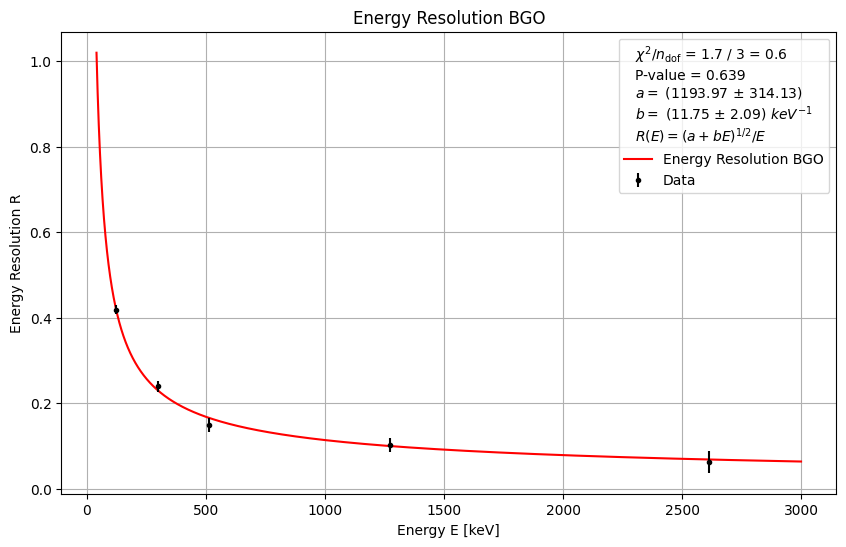

[a, b] = [1193.9696278006597, 11.747016302900716]
[0.4186995025168474, 0.2392991664472233, 0.14985892217620853, 0.10228569361851293, 0.06280908492558473]
[0.010719852571282848, 0.013058433484213927, 0.016341327778532908, 0.01642888947764915, 0.025384380643693805]


In [35]:
def Knoll_func(x, a, b):
    return np.sqrt(a+b*x)/x

ls7 = LeastSquares(energia1, R, err_R, Knoll_func)
m7 = Minuit(ls7, a=1, b=1)
m7.migrad()
m7.hesse()
display(m7)

plt.subplots(figsize=(10, 6))
xaxis = np.linspace(40, 3000, 10000)
yaxis = Knoll_func(xaxis, *m7.values)
plt.plot(xaxis, yaxis, label='Energy Resolution BGO', color='red')
plt.errorbar(energia1, R, err_R, fmt='.', linestyle='', color='black', label='Data')
plt.xlabel('Energy E [keV]')
plt.ylabel('Energy Resolution R')

fit_info = [f"$\\chi^2$/$n_\\mathrm{{dof}}$ = {m7.fval:.1f} / {m7.ndof:.0f} = {m7.fval/m7.ndof:.1f}",]
p_value = (1. - chi2.cdf(m7.fval, df=m7.ndof))
fit_info.append(f"P-value = {p_value:.3f}")
fit_info.append('$a = $ ({0:.2f} $\\pm$ {1:.2f})'.format(m7.values['a'], m7.errors['a']))
fit_info.append('$b = $ ({0:.2f} $\\pm$ {1:.2f})'.format(m7.values['b'], m7.errors['b']) + ' $keV^{-1}$')
fit_info.append(r'$R(E) = (a+bE)^{1/2}/E$')
plt.legend(title="\n".join(fit_info), frameon=True)

plt.title('Energy Resolution BGO')
plt.grid()
plt.savefig('risoluzione_energetica_BGO.png')
plt.show()

print(f'[a, b] = [{m7.values["a"]}, {m7.values["b"]}]')
print(f'[{R[0]}, {R[1]}, {R[2]}, {R[3]}, {R[4]}]')
print(f'[{err_R[0]}, {err_R[1]}, {err_R[2]}, {err_R[3]}, {err_R[4]}]')